In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Read in 
df11 = pd.read_csv('../data/df11.csv')

In [3]:
# Inspect
df11

,day,x1,x2,y
0,1,6.267497,C,4.603924
1,1,6.592165,C,2.319000
2,1,7.461689,A,14.341126
3,1,7.548916,A,14.588287
4,1,8.313763,B,5.284077
...,...,...,...,...
9995,60,16.125031,C,14.914215
9996,60,16.477850,C,5.508371
9997,60,16.824277,C,10.717834
9998,60,17.722692,C,9.113135


In [4]:
# Split data sets
df11_01_30 = df11[df11.day <= 30]
df11_31_45 = df11[(30 < df11.day) & (df11.day <= 45)]
df11_46_60 = df11[45 < df11.day]

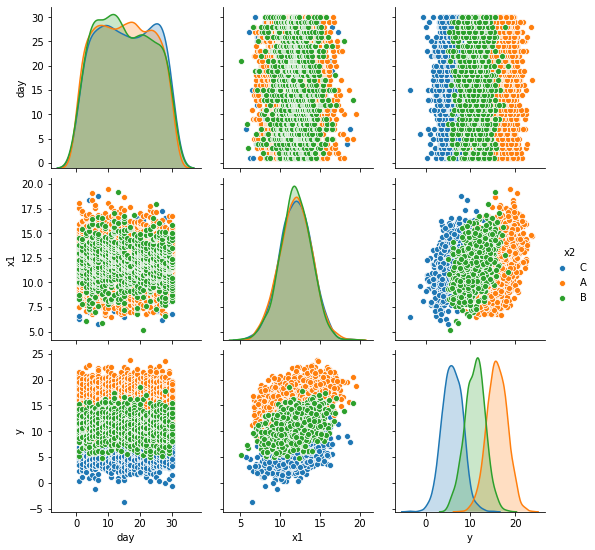

In [5]:
# Quick plot
sb.pairplot(df11_01_30, hue='x2')

# Build model on days 1-30

Stategy:

- Days 1-20 train, days 21-30 test (this data set is simple enough that I'll skip the holdout portion)
- Simple glm

In [6]:
# Split train/test/holdout
df11_01_30_train = df11_01_30[df11_01_30.day <= 20]
df11_01_30_test = df11_01_30[df11_01_30.day > 20]

# Check counts
print(f'''
Train: {df11_01_30_train.shape}
Test: {df11_01_30_test.shape}
''')


Train: (3382, 4)
Test: (1591, 4)



In [7]:
# Fit model
glm_01_30_train = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_01_30_train
).fit()

# Summarize
glm_01_30_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     4676.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:20:09   Log-Likelihood:                -7176.6
No. Observations:                3382   AIC:                         1.436e+04
Df Residuals:                    3378   BIC:                         1.439e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1519      0.212     47.913      0.000       9.736      10.567
x2[T.B]       -4.9466      0.090    -54.874      0.000      -5.123      -4.770
x2[T.C]      -10.0899      0.090   -111.863      0.000     -10.267      -9.913
x1             0.4881      0.017     28.275      0.000       0.454       0.522
==============================================================================
Omnibus:                        4.244   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                4.574
Skew:                          -0.031   Prob(JB):                        0.102
Kurtosis:                       3.169   Cond. No.                         75.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Overall AMSE on training
def mse(actual, pred):
    err = pred - actual
    return err ** 2

def amse(mse):
    return np.sum(mse) / len(mse)

amse(mse(df11_01_30_train['y'], glm_01_30_train.predict(df11_01_30_train)))

4.080115696445697

In [9]:
# Overall AMSE on testing
amse(mse(df11_01_30_test['y'], glm_01_30_train.predict(df11_01_30_test)))

4.270693095321454

A bit worse (0.2 AMSE, ~5% reduction).

Let's look at by-day AMSE

In [10]:
# AMSE by day
def amse_by_day(df, model):
    # Get predictions
    df = df.assign(p = model.predict(df))
    
    # Get MSE
    df['mse'] = df.apply(lambda x: mse(x.y, x.p), axis=1)
    
    # Aggregate
    df_agg = (
        df
        .groupby('day')
        .agg(
            n=('day', 'count'),
            mse_total=('mse', 'sum'),
            amse=('mse', lambda x: amse(x)),
        )
        .reset_index()
        .sort_values('day')
    )
    
    return df_agg

df11_01_30_train_amse = amse_by_day(df11_01_30_train, glm_01_30_train)
df11_01_30_test_amse = amse_by_day(df11_01_30_test, glm_01_30_train)

# Inspect the first
df11_01_30_train_amse

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,1,154,646.646967,4.199006
1,2,155,587.089859,3.787677
2,3,152,640.516954,4.213927
3,4,158,675.852376,4.277547
4,5,176,575.129974,3.267784
5,6,185,686.619622,3.711457
6,7,171,690.871632,4.040185
7,8,174,695.309163,3.996030
8,9,166,672.728487,4.052581
9,10,175,741.888266,4.239362


(0, 6)

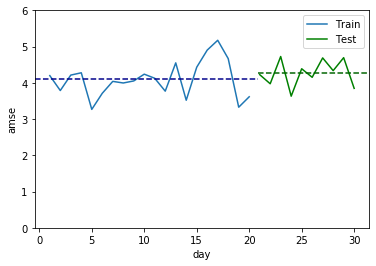

In [11]:
# Plot

# AMSEs by day
sb.lineplot(data=df11_01_30_train_amse, x='day', y='amse', label='Train')
sb.lineplot(data=df11_01_30_test_amse, x='day', y='amse', label='Test', color='green')

# AMSE means for reference
plt.axhline(df11_01_30_train_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_01_30_test_amse.amse.mean(), xmin=2/3, color='darkgreen', ls='--')

plt.ylim(0, 6)

Fit seems reasonable, so refit same model on whole data

In [12]:
# Fit model
glm_01_30 = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_01_30
).fit()

# Summarize
glm_01_30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     6920.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:20:14   Log-Likelihood:                -10589.
No. Observations:                4973   AIC:                         2.119e+04
Df Residuals:                    4969   BIC:                         2.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0405      0.178     56.278      0.000       9.691      10.390
x2[T.B]       -4.9676      0.075    -65.954      0.000      -5.115      -4.820
x2[T.C]      -10.0345      0.074   -135.972      0.000     -10.179      -9.890
x1             0.4958      0.015     34.095      0.000       0.467       0.524
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.778
Skew:                          -0.015   Prob(JB):                        0.678
Kurtosis:                       3.053   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# Overall AMSE on testing
amse(mse(df11_01_30['y'], glm_01_30.predict(df11_01_30)))

4.1400460054524935

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

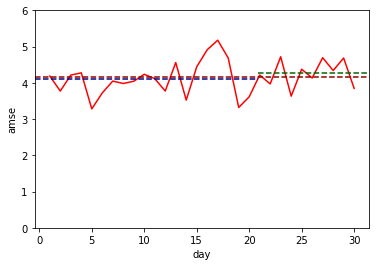

In [14]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day
sb.lineplot(data=df11_01_30_amse, x='day', y='amse', color='red')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), color='darkred', ls='--')

# AMSE means for reference
plt.axhline(df11_01_30_train_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_01_30_test_amse.amse.mean(), xmin=2/3, color='darkgreen', ls='--')

plt.ylim(0, 6)

As expected, performs slightly worse on original training data but better than on test data (because that's feeding into the model now).

# Extend to days 31-45

In [15]:
# Overall AMSE
amse(mse(df11_31_45['y'], glm_01_30.predict(df11_31_45)))

5.000134425888234

Noticably worse (slightly less than 25%)

In [16]:
# Daily AMSEs
df11_31_45_amse = amse_by_day(df11_31_45, glm_01_30)
df11_31_45_amse

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,31,153,580.872111,3.796550
1,32,158,676.985327,4.284717
2,33,160,740.787972,4.629925
3,34,185,789.438790,4.267237
4,35,161,930.086138,5.776933
5,36,190,964.464658,5.076130
6,37,176,847.927265,4.817769
7,38,160,805.685759,5.035536
8,39,154,739.944200,4.804832
9,40,164,881.007037,5.371994


<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

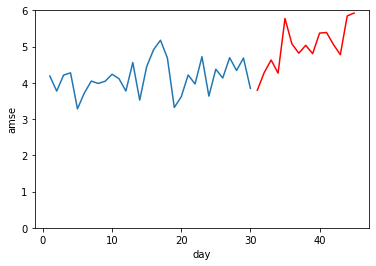

In [17]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='red')

plt.ylim(0, 6)

It looks like the model is, on average, getting worse as days increases.

So now the important question: **What do we do about it?**

This depends a lot on the use case:

- If we were working in auto insurance where it is a long process to deploy a pricing model (car insurance being legally required makes it a "public good" and hence subject to a regulation and scrutiny), then there's probably not much we can do about it in the short term.
- If we were working in digital marketing where a variety of things can change (sometimes very rapidly) about what we are trying to predict, then it might make sense to regularly (and maybe automatically) refit the model (or use "online" models that continuously learn).

In either case, it's worthwhile to try to understand **why** this is changing.  Some common things that can be happening, all generally under an umbrella called "model drift":

- "Distribution drift" - The distribution of the predictor variables changes
    - E.g. since the model is getting worse, maybe the feature combinations with the worst predictions are becoming more common and skewing the results to look worse
- "Effect drift" - The relationship between your predictors and the target variable changing
    - E.g. since the model is getting worse, maybe certain features are becoming less predictive or a variable that previously seemed unpredictive is becoming more predictive
    
Let's investigate both here.

### Distributional drift

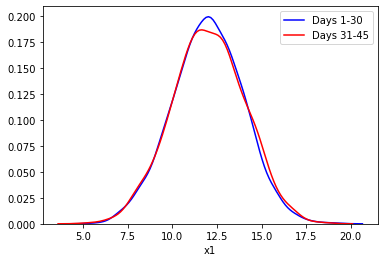

In [18]:
# x1
sb.distplot(df11_01_30['x1'], hist=False, color='blue', label='Days 1-30')
sb.distplot(df11_31_45['x1'], hist=False, color='red', label='Days 31-45')

<ipython-input-19-eb89008b1f62>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


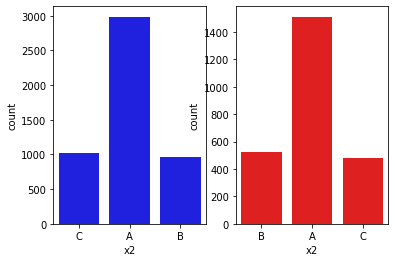

In [19]:
# x2
fig, ax = plt.subplots(1,2)
sb.countplot(df11_01_30['x2'], color='blue', label='Days  1-30', ax=ax[0])
sb.countplot(df11_31_45['x2'], color='red', label='Days 31-45', ax=ax[1])
fig.show()

Doesn't seem to be much difference here.

### Effect drift

<ipython-input-20-7d3371dcf9d9>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


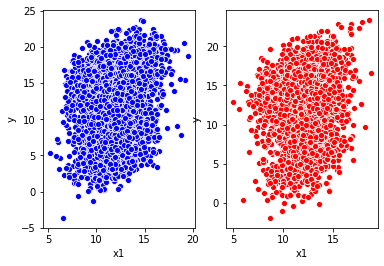

In [20]:
# x1
fig, ax = plt.subplots(1,2)
sb.scatterplot(data=df11_01_30, x='x1', y='y', color='blue', ax=ax[0])
sb.scatterplot(data=df11_31_45, x='x1', y='y', color='red', ax=ax[1])
fig.show()

Can't tell much from this, let's try the univariate plots.

In [21]:
def plot_univariate(df, x, y, model_fit, n_bins=10):
    # Create copy of dataframe
    df = df.copy()
    
    # Add prediction
    df = df.assign(p = model_fit.predict(df))
    
    # If x is numeric, bin into groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1     n     y_mean      y_sd     p_mean      p_sd
0    (5.177, 6.623]    10   5.162459  4.134274   6.079298  3.507209
1    (6.623, 8.054]   117  11.341363  4.631949  11.027859  3.952456
2    (8.054, 9.486]   394  11.569988  4.488202  11.589004  4.040763
3   (9.486, 10.918]   931  11.970219  4.536307  12.019979  4.068679
4   (10.918, 12.35]  1386  12.792308  4.508029  12.811572  3.995793
5   (12.35, 13.781]  1209  13.426073  4.485692  13.399994  4.071107
6  (13.781, 15.213]   679  14.215014  4.556657  14.203680  4.020922
7  (15.213, 16.645]   195  14.703835  4.772391  14.562790  4.215913
8  (16.645, 18.077]    45  17.417595  2.706044  17.639486  2.441512
9  (18.077, 19.508]     7  15.281896  5.017998  15.815682  4.844892


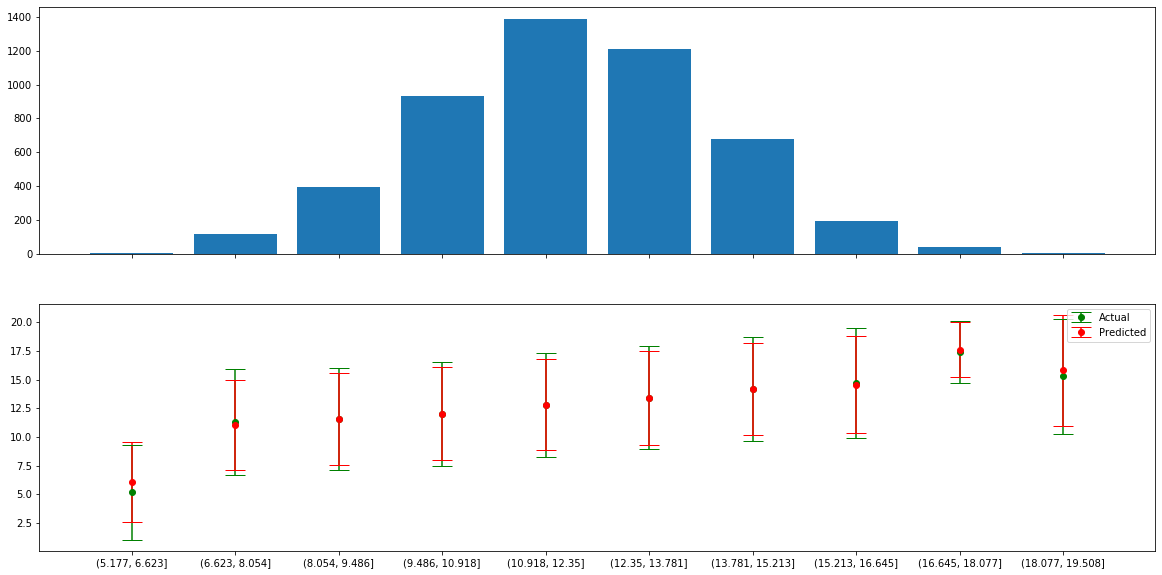

In [22]:
# x1 - Days 1-30
plot_univariate(df11_01_30, 'x1', 'y', glm_01_30)

                 x1    n     y_mean      y_sd     p_mean      p_sd
0    (4.934, 6.328]    5  10.962993  6.081656  10.842216  4.411791
1    (6.328, 7.709]   35  11.390657  3.468650  11.757469  3.193015
2    (7.709, 9.089]  154  11.339126  4.560769  11.652853  3.837165
3   (9.089, 10.469]  358  11.765473  4.401273  12.197715  3.886153
4   (10.469, 11.85]  632  11.906249  4.452539  12.344865  4.054578
5    (11.85, 13.23]  632  12.663609  4.573427  13.207305  3.996296
6    (13.23, 14.61]  429  13.473148  4.672592  14.073693  3.946636
7    (14.61, 15.99]  206  14.115226  4.423791  14.824011  3.889536
8   (15.99, 17.371]   54  14.252533  4.577293  15.351083  3.868145
9  (17.371, 18.751]    7  17.635172  5.449752  16.140584  3.990788


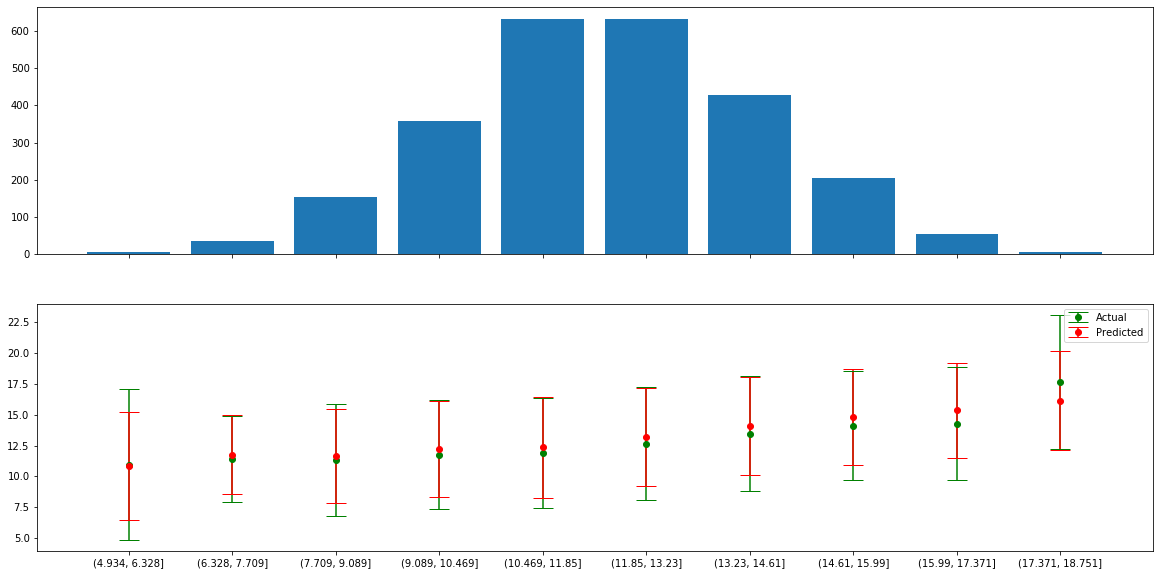

In [23]:
# x1, Days 31-45
plot_univariate(df11_31_45, 'x1', 'y', glm_01_30)

  x2     n     y_mean      y_sd     p_mean      p_sd
0  A  2985  15.989161  2.274154  15.989161  0.998437
1  B   967  11.012144  2.240908  11.012144  0.947129
2  C  1021   5.952296  2.240771   5.952296  0.977844


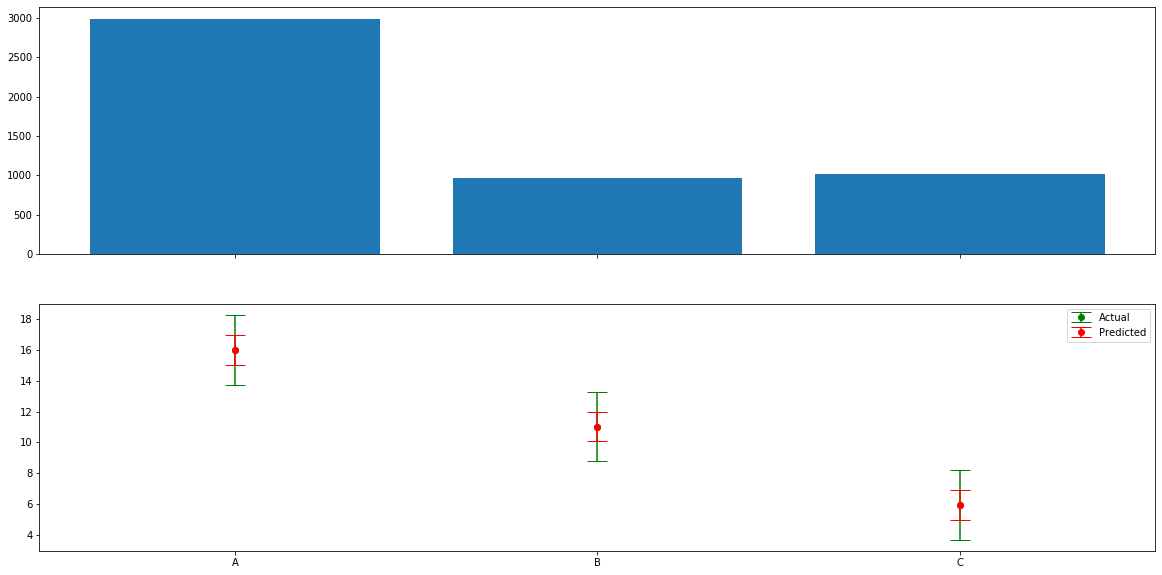

In [24]:
# x2 - Days 1-30
plot_univariate(df11_01_30, 'x2', 'y', glm_01_30)

  x2     n     y_mean      y_sd     p_mean      p_sd
0  A  1512  15.473255  2.424316  15.991660  1.035771
1  B   522  10.601123  2.173842  11.056083  0.988160
2  C   478   5.421246  2.268198   5.980448  0.939646


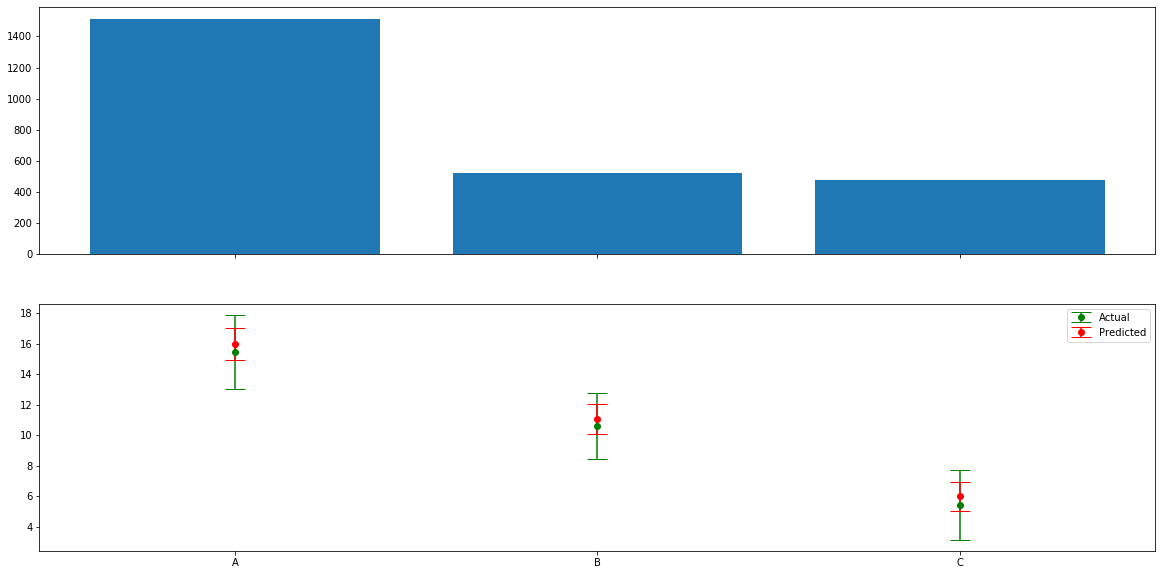

In [25]:
# x2 - Days 31-45
plot_univariate(df11_31_45, 'x2', 'y', glm_01_30)

Looks like our model is over-predicting on days 31-45 despite looking good on days 1-30.  So we have some evidence of effect drift.

For comparison, let's fit the same glm specification on days 31-40 and compare the AMSEs of this new model and the current one on days 41-45

In [26]:
# Split train/test/holdout
df11_31_45_train = df11_31_45[df11_31_45.day <= 40]
df11_31_45_test = df11_31_45[df11_31_45.day > 40]

# Check counts
print(f'''
Train: {df11_31_45_train.shape}
Test: {df11_31_45_test.shape}
''')


Train: (1661, 4)
Test: (851, 4)



In [27]:
# Fit model
glm_31_45_train = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_31_45_train
).fit()

# Summarize
glm_31_45_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1895.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:20:28   Log-Likelihood:                -3636.8
No. Observations:                1661   AIC:                             7282.
Df Residuals:                    1657   BIC:                             7303.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8569      0.320     30.843      0.000       9.230      10.484
x2[T.B]       -4.8594      0.133    -36.642      0.000      -5.120      -4.599
x2[T.C]      -10.0471      0.142    -70.521      0.000     -10.326      -9.768
x1             0.4808      0.026     18.500      0.000       0.430       0.532
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                1.172
Skew:                          -0.063   Prob(JB):                        0.557
Kurtosis:                       3.033   Cond. No.                         74.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# Previous model summary for comparison
glm_01_30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     6920.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:20:30   Log-Likelihood:                -10589.
No. Observations:                4973   AIC:                         2.119e+04
Df Residuals:                    4969   BIC:                         2.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0405      0.178     56.278      0.000       9.691      10.390
x2[T.B]       -4.9676      0.075    -65.954      0.000      -5.115      -4.820
x2[T.C]      -10.0345      0.074   -135.972      0.000     -10.179      -9.890
x1             0.4958      0.015     34.095      0.000       0.467       0.524
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.778
Skew:                          -0.015   Prob(JB):                        0.678
Kurtosis:                       3.053   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see some changes in coefficient estimates, but the 95% confidence intervals overlap so hard to draw any definitive conclusion about changing effects.  This is where partial dependence plots can be useful if we use a model framework besides GLMs.

Plot AMSEs.

In [29]:
# Previous AMSE on days 41-45
amse(mse(df11_31_45_test['y'], glm_01_30.predict(df11_31_45_test)))

5.409093326410996

In [30]:
# New AMSE on days 41-45
amse(mse(df11_31_45_test['y'], glm_31_45_train.predict(df11_31_45_test)))

4.928958945454168

Still worse than the original data but definitely better!

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)
<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

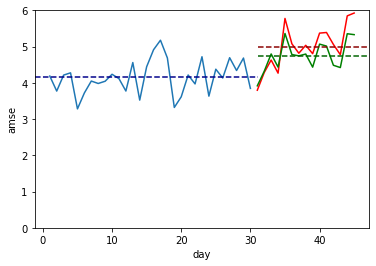

In [31]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45 (Previous model)
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='red')

# AMSEs by day - Days 31-45 (New model)
df11_31_45_amse_train = amse_by_day(df11_31_45, glm_31_45_train)
sb.lineplot(data=df11_31_45_amse_train, x='day', y='amse', color='green')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_31_45_amse.amse.mean(), xmin=2/3, color='darkred', ls='--')
plt.axhline(df11_31_45_amse_train.amse.mean(), xmin=2/3, color='darkgreen', ls='--')

plt.ylim(0, 6)

The new model seems to do slightly worse on the first few days but after that does better every day.  And it looks like the difference might be increasing towards the latter days.

So now we need to decide **what** to do about this.  Our options:

- Continue using the previous model
    - Doesn't make sense because more recent data seems to help the model
- Build a new model including both the previous data and the new data
    - Questionable because of the effect drift we seem to have found earlier
    - We could also "weight" the more recent data to give it more importance when fitting the model (e.g. weight each observation in days 31-45 with `1` and days 0-30 with something less than that like `0.5`)
- Build a model using only the new data
    - Throws away all of that previous data and forces us to extend a new model on half of the data we previously had
- Build a model and use `day` as a predictor to control for the 
    - Increases the complexity of the model and forces us to extraplote that this trend will continue into the future (e.g. days 46+ will exhibit this trend and not change again)
    
There is no easy answer to this type of situation, and answers might vary depending on the problem.  With what we know right now for this problem (and assuming that the problem is low stakes), let's just refit on the new data.  Fitting a new model with all of the data (weighted or not) will just look at least slightly worse on the most recent data.

In reality, we might try multiple different approaches (e.g. by deploying multiple models to production and evaluating over upcoming days).

In [37]:
# Fit model
glm_31_45 = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_31_45
).fit()

# Summarize
glm_31_45.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     2901.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:21:45   Log-Likelihood:                -5513.3
No. Observations:                2512   AIC:                         1.103e+04
Df Residuals:                    2508   BIC:                         1.106e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2811      0.262     39.210      0.000       9.767      10.795
x2[T.B]       -4.9000      0.110    -44.393      0.000      -5.116      -4.684
x2[T.C]      -10.0724      0.114    -88.286      0.000     -10.296      -9.849
x1             0.4325      0.021     20.268      0.000       0.391       0.474
==============================================================================
Omnibus:                        1.309   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                1.343
Skew:                          -0.054   Prob(JB):                        0.511
Kurtosis:                       2.967   Cond. No.                         74.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)
<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

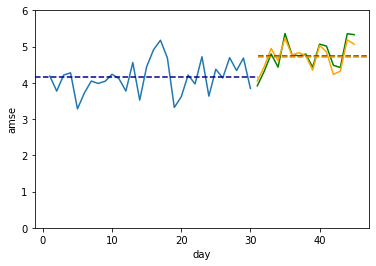

In [40]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45 (New model on training)
sb.lineplot(data=df11_31_45_amse_train, x='day', y='amse', color='green')

# AMSEs by day - Days 31-45 (New model on days 31-45)
df11_31_45_amse = amse_by_day(df11_31_45, glm_31_45)
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='orange')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_31_45_amse_train.amse.mean(), xmin=2/3, color='darkgreen', ls='--')
plt.axhline(df11_31_45_amse.amse.mean(), xmin=2/3, color='darkorange', ls='--')

plt.ylim(0, 6)

# Extend to days 46-60

In [42]:
# Overall AMSE
amse(mse(df11_46_60['y'], glm_31_45.predict(df11_46_60)))

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'D' does not match any of the expected levels (expected: ['A', 'B', 'C'])
    y ~ x1 + x2
             ^^

It looks like we have a new value of x2.  Fun!

Ideally we build our models to be able to handle situations like this.  Depending on the situation, we could do the following here:

- Have the model error out completely
    - But this is not acceptable in situations where models need to quickly return a prediction and have near 100% up-time (e.g. fraud modelling)
- Have the model error out with some sort of "fallback" option
    - For example, if a model errors out at scoring time due to a new value simply return the previously estimated overall mean
- Remove rows with `x2 = 'D'`
    - But, generally, we shouldn't remove data because this likely reflects something meaningful (e.g. a shift in our underlying data or a new data collection error)
- Use a modelling approach that can 
    - Requires a lot of upkeep and monitoring to make sure we are balancing fitting on new values with not rapidly changing predictions due to noisy data


The best choice really depends on the context.

- For example, if we need to have a model that can work with any new potential value despite not having seen it, we could create an "Other" category that all new values get lumped into for returning a prediction.
- Conversely, we could return a "prediction" the results in a particular business process happening (e.g. "send this video to a human to look at because we have no idea what to do with it")

Keep in mind that different modelling frameworks and implementations can need different ways of preventing or dealing with these errors.  For statsmodel formula-built models, it will yell at us for new values in a way that is generally informative but trees can natively error in a different way (e.g. it sees too many "columns" since we only pass in a matrix, or it might just ignore any columns past how many it expects and hence our features can be misidentified at scoring time because names are not tracked).

In [182]:
# Fit model
glm = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_01_30
).fit()

# Summarize
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     6920.
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        09:26:59   Log-Likelihood:                -10589.
No. Observations:                4973   AIC:                         2.119e+04
Df Residuals:                    4969   BIC:                         2.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0405      0.178     56.278      0.000       9.691      10.390
x2[T.B]       -4.9676      0.075    -65.954      0.000      -5.115      -4.820
x2[T.C]      -10.0345      0.074   -135.972      0.000     -10.179      -9.890
x1             0.4958      0.015     34.095      0.000       0.467       0.524
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.778
Skew:                          -0.015   Prob(JB):                        0.678
Kurtosis:                       3.053   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
# Overall AMSE
def mse(actual, pred):
    err = pred - actual
    return err ** 2

def amse(mse):
    return np.sum(mse) / len(mse)

amse(mse(df11_01_30['y'], glm.predict(df11_01_30)))

4.1400460054524935

In [184]:
# AMSE by day
def amse_by_day(df):
    # Get predictions
    df = df.assign(p = glm.predict(df))
    
    # Get MSE
    df['mse'] = df.apply(lambda x: mse(x.y, x.p), axis=1)
    
    # Aggregate
    df_agg = (
        df
        .groupby('day')
        .agg(
            n=('day', 'count'),
            mse_total=('mse', 'sum'),
            amse=('mse', lambda x: amse(x)),
        )
        .reset_index()
        .sort_values('day')
    )
    
    return df_agg

df11_01_30_amse = amse_by_day(df11_01_30)
df11_01_30_amse

<ipython-input-183-0e1bf3cb6f68>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,1,154,644.925767,4.187830
1,2,155,584.814040,3.772994
2,3,152,640.470051,4.213619
3,4,158,675.633666,4.276162
4,5,176,577.542738,3.281493
5,6,185,688.455081,3.721379
6,7,171,692.421711,4.049250
7,8,174,692.931413,3.982364
8,9,166,671.317799,4.044083
9,10,175,741.328269,4.236162


(0, 6)

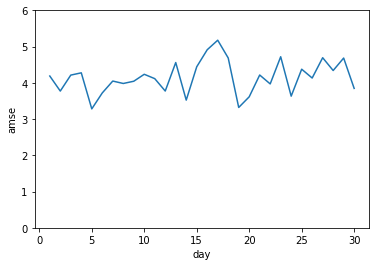

In [185]:
# Plot
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')
plt.ylim(0, 6)

# Extend model to days 31-45

In [186]:
df11_31_45_amse = amse_by_day(df11_31_45)
df11_31_45_amse

<ipython-input-183-0e1bf3cb6f68>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,31,153,580.872111,3.796550
1,32,158,676.985327,4.284717
2,33,160,740.787972,4.629925
3,34,185,789.438790,4.267237
4,35,161,930.086138,5.776933
5,36,190,964.464658,5.076130
6,37,176,847.927265,4.817769
7,38,160,805.685759,5.035536
8,39,154,739.944200,4.804832
9,40,164,881.007037,5.371994


(0, 10)

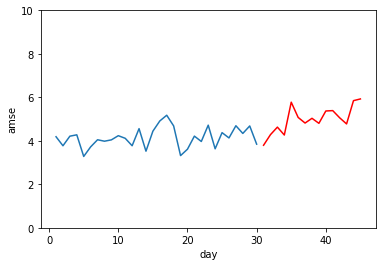

In [187]:
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='red')
plt.ylim(0, 10)

# Extend model to days 46-60

In [188]:
df11_46_60_amse = amse_by_day(df11_46_60)
df11_46_60_amse

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'D' does not match any of the expected levels (expected: ['A', 'B', 'C'])
    y ~ x1 + x2
             ^^

In [189]:
# Dropping category D
df11_46_60_amse = amse_by_day(df11_46_60[df11_46_60.x2 != 'D'])
df11_46_60_amse

<ipython-input-183-0e1bf3cb6f68>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,46,152,795.184140,5.231475
1,47,172,1146.326137,6.664687
2,48,184,944.235121,5.131713
3,49,154,1615.415870,10.489713
4,50,158,1555.624425,9.845724
5,51,141,1346.847655,9.552111
6,52,152,1719.110742,11.309939
7,53,153,1427.096782,9.327430
8,54,141,1797.920716,12.751211
9,55,149,1499.476178,10.063599


(0, 10)

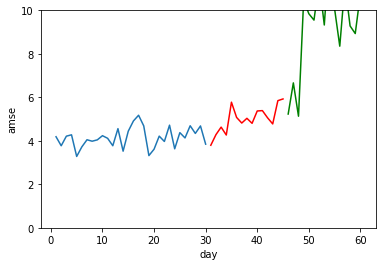

In [190]:
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='red')
sb.lineplot(data=df11_46_60_amse, x='day', y='amse', color='green')
plt.ylim(0, 10)

In [2]:
# Read in 
df9 = pd.read_csv('../data/df9.csv')

In [3]:
# Inspect
df9

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-1.912877,-0.509738,1.935923,-2.119992,0.474137,3.647543,A2,B2,C33,D3,-23.858957
1,-0.341252,0.341502,2.268666,-0.948835,-0.492523,4.159113,A1,B4,C32,D2,4.795576
2,0.658157,-0.347933,3.104409,0.236928,0.359240,6.498557,A1,B4,C4,D2,16.359090
3,2.288540,-1.028834,3.554489,-0.215137,-0.436760,7.154874,A2,B1,C11,D3,-24.550723
4,0.618358,-1.526877,3.857197,-0.343902,0.098206,7.857794,A2,B2,C12,D3,-23.033020
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.377935,-0.810448,3.658649,0.614948,-1.292935,7.227878,A1,B1,C13,D3,14.729703
996,0.968435,1.273159,3.449217,-0.073787,1.088958,6.701653,A1,B4,C42,D2,5.337900
997,0.919181,-1.518937,3.427333,1.152154,0.039267,6.797440,A2,B1,C22,D3,-8.781643
998,0.248702,-0.184816,2.923806,1.188720,-0.361918,6.040283,A2,B5,C11,D2,-15.494192


# Let's test a variety of holdouts on each of our four model types

***Ignoring x9 for the sake of simplicity***

- GLM
- Tree
- Random Forest
- GBM

General flow for each algorithm:

- Set sequence of random seeds
- For each seed:
    - Split into train/test (70/30 split)
    - Fit model on train
    - Evaluate on test
    - Save train errors and test errors (for comparing both within-seed and across seed variation)

### Build out for GLM first

In [4]:
def fit_glm(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Split train/test
    df_train, df_test = train_test_split(df9, test_size=.3)
    
    # Fit model
    glm = smf.ols(
        formula='''y ~ x1 + np.power(x1, 2) + np.power(x1, 3) +
                       np.power(x2, 2)*x7 +
                       x4 +
                       x5 + np.power(x5, 2) + np.power(x5, 3) +
                       x8 + x10''',
        data=df_train
    ).fit()    
    
    # Return dictionary of train and test errors
    return {
        'train_err': df_train['y'] - glm.predict(df_train),
        'test_err': df_test['y'] - glm.predict(df_test)
    }

In [5]:
# Test for one seed
glm_0 = fit_glm(0)

# Inspect
glm_0

{'train_err': 105     4.606279
 68      9.186812
 479    -0.061038
 399    -1.155023
 434    -9.787948
          ...    
 835     4.867136
 192    -2.042414
 629     7.799803
 559    -4.663748
 684    13.816848
 Length: 700, dtype: float64,
 'test_err': 993    -7.538324
 859     7.336013
 298     1.962501
 553   -12.367856
 672    -3.354093
          ...    
 167    -1.325015
 998    -8.286180
 984    -8.638309
 491   -12.156354
 10     -0.305572
 Length: 300, dtype: float64}

In [6]:
# Compare average mean squared errors
def amse(err):
    return np.sum(err ** 2) / len(err)

print(f'''
Train error: {amse(glm_0['train_err'])}
Test error: {amse(glm_0['test_err'])}
''')


Train error: 60.668959060796496
Test error: 61.52048447221103



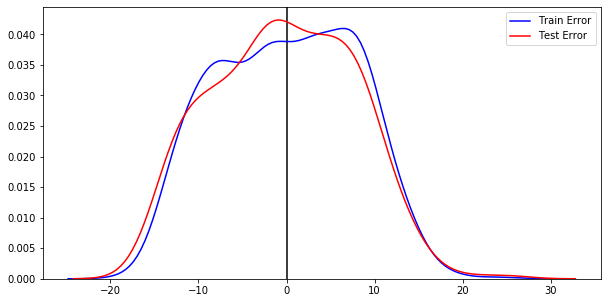

In [7]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
sb.distplot(glm_0['train_err'], hist=False, color='blue', label='Train Error')
sb.distplot(glm_0['test_err'], hist=False, color='red', label='Test Error')

Bit hard to tell in the graph, but average MSE is a little bit worse on the test data.  Ideally we want to see the train and test errors look more or less the same, but it's fairly common to have test metrics that looks a little bit worse that train metrics.  Comparing the relative difference can help, which here is about 2% (~1/60).

Now let's summarize 10 different train/test splits.

In [8]:
# Fit 10 different train/test splits
glm_err = []
for i in range(10):
    glm_err.append(fit_glm(i))

In [9]:
# Inspect one
glm_err[3]

{'train_err': 926    -0.479961
 411     7.413181
 224   -12.184692
 14     -1.248976
 170   -10.614919
          ...    
 952   -12.984785
 643    10.705868
 249    -2.019822
 664     1.933117
 874    12.383082
 Length: 700, dtype: float64,
 'test_err': 642    -4.146929
 762     7.436569
 909   -13.647234
 199     1.123322
 586    -6.762614
          ...    
 466   -12.462900
 654     3.997120
 279     2.702487
 945     6.245419
 186    -7.323468
 Length: 300, dtype: float64}

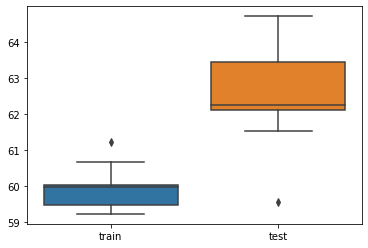

In [10]:
# Inspect train/test AMSEs
def plot_amse(err_list):
    train_amse = [amse(x['train_err']) for x in err_list]
    test_amse = [amse(x['test_err']) for x in err_list]
    sb.boxplot(
        x = np.repeat(['train', 'test'], 10),
        y = train_amse + test_amse
    )
    
plot_amse(glm_err)

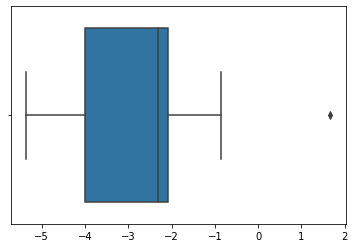

In [11]:
# Inspect the difference in train/test AMSE
def plot_diff_amse(err_list):
    diff_amse = [amse(x['train_err']) - amse(x['test_err']) for x in err_list]
    sb.boxplot(diff_amse)
    
plot_diff_amse(glm_err)

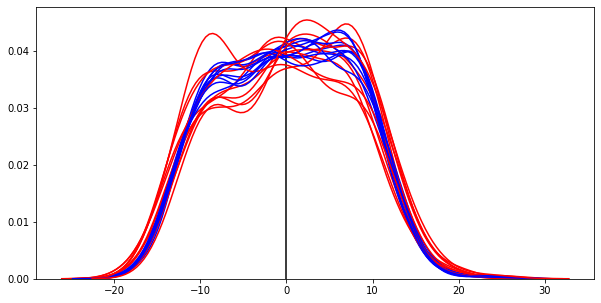

In [12]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in glm_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Things that stick out:

- Out of 10 iterations, the lowest test eror is still higher than the worst train error
- We consistently see test perform 2-4 AMSE worse than training (roughly 3-7% worse)
- Oddly, one iteration had test performance better than the train performance

Now replicate for the other model types

### Decision tree

In [13]:
def fit_tree(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Create X/y
    predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
    X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    # Fit model
    tree = DecisionTreeRegressor(
        max_depth=10,
        min_samples_leaf=25,
    ).fit(X_train, y_train)
    
    # Return dictionary of train and test errors
    return {
        'train_err': y_train - tree.predict(X_train),
        'test_err': y_test - tree.predict(X_test)
    }

In [14]:
# Fit 10 different train/test splits
tree_err = []
for i in range(10):
    tree_err.append(fit_tree(i))

In [15]:
# Inspect one
tree_err[3]

{'train_err': 926     0.024632
 411    15.161784
 224    -4.938915
 14      4.491905
 170    -6.882096
          ...    
 952   -12.745105
 643     9.262613
 249    -5.400989
 664     9.069951
 874     9.998611
 Name: y, Length: 700, dtype: float64,
 'test_err': 642    -9.886729
 762     4.148707
 909   -10.455647
 199    26.034523
 586    -7.815596
          ...    
 466   -19.681046
 654     1.755108
 279    -3.101111
 945    -0.147631
 186    -3.551473
 Name: y, Length: 300, dtype: float64}

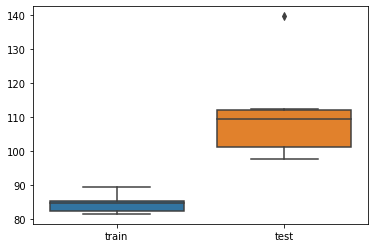

In [16]:
# Inspect train/test AMSEs
plot_amse(tree_err)

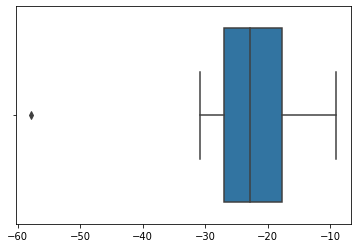

In [17]:
# Inspect the difference in train/test AMSE
plot_diff_amse(tree_err)

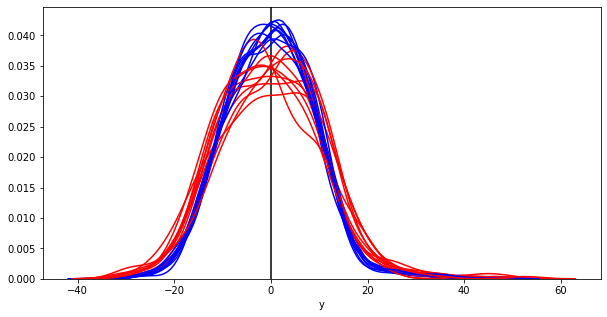

In [18]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in tree_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Vastly worse than the GLM!  Even the best performing iteration has a worse error than the worst performing GLM iteration.

### Random Forest

In [19]:
def fit_rf(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Create X/y
    predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
    X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    # Fit model
    tree = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=25,
        max_features='sqrt',
        n_jobs=-1
    ).fit(X_train, y_train)
    
    # Return dictionary of train and test errors
    return {
        'train_err': y_train - tree.predict(X_train),
        'test_err': y_test - tree.predict(X_test)
    }

In [20]:
# Fit 10 different train/test splits
rf_err = []
for i in range(10):
    rf_err.append(fit_rf(i))

In [21]:
# Inspect one
rf_err[3]

{'train_err': 926     3.212988
 411     8.943500
 224   -10.247187
 14      7.609291
 170    -9.943426
          ...    
 952    -6.102811
 643    14.674094
 249    -8.115800
 664     3.307289
 874    10.902323
 Name: y, Length: 700, dtype: float64,
 'test_err': 642    -6.483440
 762     1.112102
 909   -12.279110
 199    31.172801
 586    -4.755280
          ...    
 466   -14.663799
 654     9.953853
 279     3.085640
 945     2.991935
 186    -7.535407
 Name: y, Length: 300, dtype: float64}

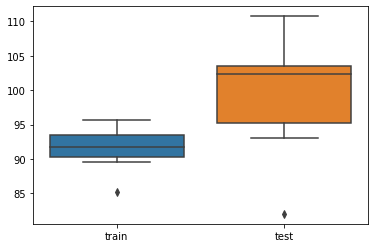

In [22]:
# Inspect train/test AMSEs
plot_amse(rf_err)

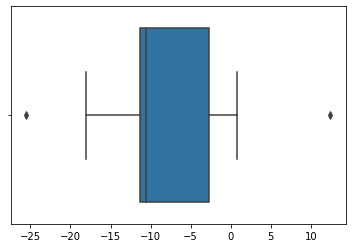

In [23]:
# Inspect the difference in train/test AMSE
plot_diff_amse(rf_err)

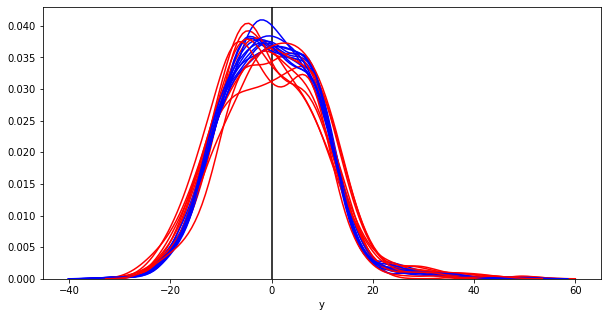

In [24]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in rf_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Interesting!  Train performance looks worse on RF than on the decision (medians of ~85 and ~92, respectively), but test performance is better (medians of ~110 and ~103, respectively).  But both worse than GLM.

### GBM

In [25]:
def fit_gbm(seed):
    # Set seed (you could also use random_state in train_test_split)
    np.random.seed(seed)
    
    # Create X/y
    predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
    X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    
    # Fit model
    tree = GradientBoostingRegressor(
        loss='ls',
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        max_features='sqrt',
        n_iter_no_change=1  # Used for early stopping.  The moment that the performance looks worse on randomly held out data, we stop building more trees.
    ).fit(X_train, y_train)
    
    # Return dictionary of train and test errors
    return {
        'train_err': y_train - tree.predict(X_train),
        'test_err': y_test - tree.predict(X_test)
    }

In [26]:
# Fit 10 different train/test splits
gbm_err = []
for i in range(10):
    gbm_err.append(fit_gbm(i))

In [27]:
# Inspect one
gbm_err[3]

{'train_err': 926     2.276893
 411     8.926064
 224   -10.409496
 14      0.368059
 170    -9.916554
          ...    
 952    -6.444186
 643    14.667977
 249    -7.845592
 664     2.886123
 874    10.652250
 Name: y, Length: 700, dtype: float64,
 'test_err': 642    -5.463866
 762     2.608858
 909   -10.851465
 199    26.277105
 586    -3.251890
          ...    
 466   -13.121135
 654     8.736846
 279     4.607689
 945     3.271966
 186    -6.284081
 Name: y, Length: 300, dtype: float64}

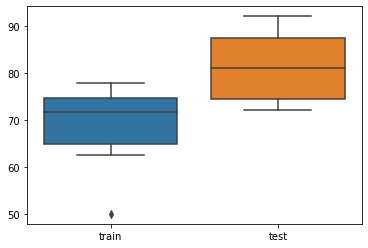

In [28]:
# Inspect train/test AMSEs
plot_amse(gbm_err)

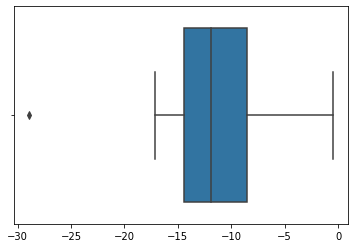

In [29]:
# Inspect the difference in train/test AMSE
plot_diff_amse(gbm_err)

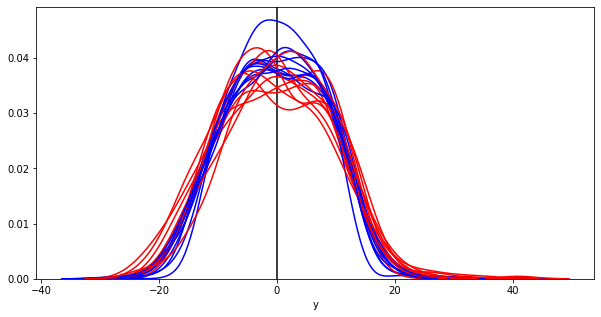

In [30]:
# Plot train and test error distributions
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
for i in gbm_err:
    sb.distplot(i['train_err'], hist=False, color='blue')
    sb.distplot(i['test_err'], hist=False, color='red')

Better than the tree and RF, not quite as good as the GLM.

Let's plot boxplots of test performance on one graph.

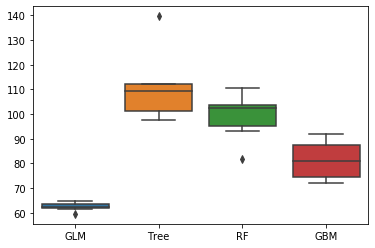

In [31]:
# Hacky
sb.boxplot(
    x = np.repeat(['GLM', 'Tree', 'RF', 'GBM'], 10),
    y = [amse(x['test_err']) for x in glm_err] +
        [amse(x['test_err']) for x in tree_err] +
        [amse(x['test_err']) for x in rf_err] +
        [amse(x['test_err']) for x in gbm_err]
)

Main takeaways:

- GLM win this data set (which makes sense because a lot of the overall signal is additive signals from individual variables)
- Tree does the worst, probably due to it's simplistic way of describing the world compared to the other models
- RF and GBM are both better than average than Tree, which is expected because with RF/GBM we're trying to improve the generalizability of basic decision trees

Remember this: Every data set is different.  Sometimes GLMs will outperform the rest, sometimes RF and GBM will reign supreme, and sometimes there isn't a clear winner. :)

# Cross-validation

Cross-validation extends the ideas we've talking about and instead separates the data into `k` distinct groups (called k-fold cross-validation.  By splitting the data into `k` distinct data sets, we're trying to maximize the general usefulness of our data to create a generalizable model by evaluating the model on many different test data sets.  It can be very useful for optimizing hyperparameters but can be computational demanding by requiring many different models to be fit if we set `k` to be high.

The basic idea:

- Split data into `k` distinct groups
- For each parameter value:
    - For each group:
        - Build a model on all groups but that group
        - Summarize model performance
    - Aggregate performance across all folks (e.g. by taking the mean)
- Pick the parameter value with the best aggregate performance
- Refit a model on the **whole** data set using that parameter!

Let's illustrate this using a basic decision to understand test what value of `min_samples_leaf` results in the best model (previously we just arbitrarily used values like 25 and 50 to represent some sort of "reasonable" percentage of the data).  Since this model fits really fast, let's do the following:

- `min_samples_leaf` values ranging from 1 to 200 by 5
- 4-fold cross-validation

In [32]:
# Get parameter values
param_values = [x for x in range(1, 200)]

# Inspect
param_values[:5], param_values[-5:]

([1, 2, 3, 4, 5], [195, 196, 197, 198, 199])

In [33]:
# Get matrices
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

         x1        x2        x3        x4        x5        x6  x7_A1  x7_A2  \
0 -1.912877 -0.509738  1.935923 -2.119992  0.474137  3.647543      0      1   
1 -0.341252  0.341502  2.268666 -0.948835 -0.492523  4.159113      1      0   
2  0.658157 -0.347933  3.104409  0.236928  0.359240  6.498557      1      0   
3  2.288540 -1.028834  3.554489 -0.215137 -0.436760  7.154874      0      1   
4  0.618358 -1.526877  3.857197 -0.343902  0.098206  7.857794      0      1   

   x8_B1  x8_B2  x8_B3  x8_B4  x8_B5  x10_D1  x10_D2  x10_D3  
0      0      1      0      0      0       0       0       1  
1      0      0      0      1      0       0       1       0  
2      0      0      0      1      0       0       1       0  
3      1      0      0      0      0       0       0       1  
4      0      1      0      0      0       0       0       1  

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [34]:
# For each parameter value, evaluate 4-fold cross-validation
scores = []
for p in param_values:
    # Initialize tree
    tree = DecisionTreeRegressor(
        min_samples_leaf=p,
    )
    
    # Get scores
    cv_score = cross_val_score(tree, X, y, cv=4, scoring='neg_mean_squared_error')  # By default uses the 
    
    # Save the mean score
    scores += [cv_score.mean()]

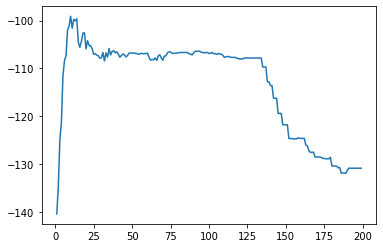

In [35]:
# Plot
sb.lineplot(x=param_values, y=scores)

In [36]:
# Get the number of minimum samples with the best performance (here, the highest value)
best_index = scores.index(max(scores))
best_score = scores[best_index]
best_param = param_values[best_index]

# Inspect
best_param, best_score

(10, -99.08170246677605)

10 samples, quite a bit lower that our previously used values.

Lastly, we refit the whole model using this parameter.

In [37]:
best_tree = DecisionTreeRegressor(
    min_samples_leaf=best_param,
).fit(X, y)

In [38]:
# In case you want to see all scoring function supported by scikit
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

Basically all practical and useful models, however, have much more than one hyperparameter (even basic decision trees do) so in reality we will test multiple sets of parameters.  There are generally two ways to identify the sets of parameters to test:

- Grid search
    - Creates a fixed mesh across your hyperparameter space (e.g. what we did above by creating a grid from 1 to 100 incrementing by 1)
    - Works well when you a lot computation power to handle a lot of iterations and/or have some sort of prior knowledge for what sets of parameter ranges make the most sense
- Random search
    - Creates a random mesh across your hyperparameter space (e.g. if we have randomly sampled 10 values from 1 to 100)
    - Can work well if you have limited computational power and/or no sort of prior knowledge for what sets of parameter ranges make the most sense (e.g. could be used to find initial sets that seem good and then grid searching around those sets to fine tune them a little)